# 範例重點
學習如何在 keras 中加入 BatchNorm <br />
知道有無 BN 對訓練的影響 <br />
比較 BN 在不同 batch size 下的效果

In [0]:
import os
import keras
from keras.layers import Input, Dense

#os.environ["CUDA_VISIBLE_DEVICES"] = ""
!nvidia-smi

Using TensorFlow backend.


Mon Jul 22 02:57:29 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    31W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
(train_x, train_y), (test_x, test_y) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
def preproc_x(x, flatten = True):
    x = x / 255.0
    if flatten :
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes = 10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y

In [0]:
train_x = preproc_x(train_x)
test_x = preproc_x(test_x)
train_y = preproc_y(train_y)
test_y = preproc_y(test_y)

In [0]:
def build_mlp(input_shape, output_units = 10, num_neurons = [512, 256, 128]):
    
    input_layer = Input(input_shape, name = "main_input")
    
    for i , n_units in enumerate(num_neurons):
        
        if i == 0 :
            x = Dense(units = n_units, activation = 'relu', name = "hidden_layer" + str(i+1)) (input_layer)
        else:
            x = Dense(units = n_units, activation = 'relu', name = "hidden_layer" + str(i+1)) (x)
            
        x = keras.layers.BatchNormalization()(x)
        
    output_layer = Dense(units = output_units, activation = 'softmax', name = "main_output") (x)
    
    model = keras.models.Model(inputs = [input_layer], outputs = [output_layer])
    return model

In [0]:
#Setting hyper-parameters
lr = 1e-3
epochs = 50
batch_size = 1024
momentum = 0.95

In [0]:
model = build_mlp(input_shape = train_x.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr = lr, nesterov = True, momentum = momentum)
model.compile( optimizer = optimizer, loss = "categorical_crossentropy", metrics = ['accuracy'])
history = model.fit(train_x, train_y, epochs = epochs, batch_size = batch_size, shuffle = True, validation_data = [test_x, test_y])

W0722 03:00:31.845324 139919746578304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0722 03:00:31.949559 139919746578304 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
__________

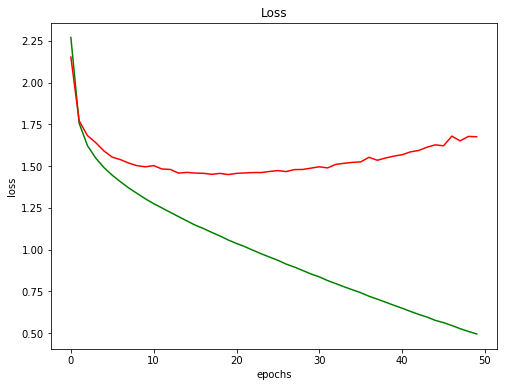

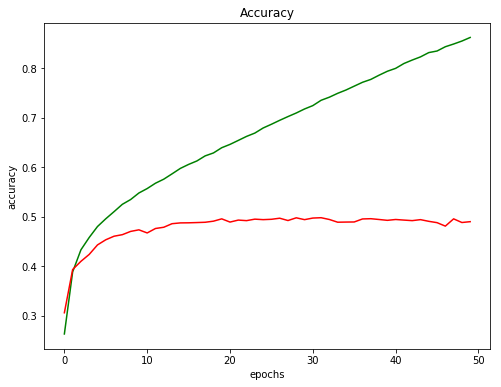

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8,6))
plt.plot(history.history['loss'], label = "train_loss", color = 'g')
plt.plot(history.history['val_loss'], label = "valid_loss", color = 'r')
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

plt.figure(figsize = (8,6))
plt.plot(history.history['acc'], label = "train_acc", color = 'g')
plt.plot(history.history['val_acc'], label = "valid_acc", color = 'r')
plt.title("Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.show()


# Work
試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異 <br />
請嘗試將 BN 放在 Activation 之前，並比較訓練結果<br />
請於 BN 放在 Input Layer 後，並比較結果

In [0]:
def build_mlp2(input_shape, output_units = 10):
    
    input_layer = Input(input_shape, name = "main_input")
    
    x = keras.layers.Dense(units = 512, activation = 'relu')(input_layer)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(units = 512, activation = 'relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(units = 256, activation = 'relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(units = 256, activation = 'relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(units = 128, activation = 'relu')(x)
    x = keras.layers.BatchNormalization()(x)
    
    output_layer = Dense(units = output_units, activation = 'softmax', name = "main_output")(x)
    
    model = keras.models.Model(inputs = [input_layer], outputs = [output_layer])
    return model

In [0]:
#Setting hyper-parameters
lr = 1e-3
epochs = 50
batch_sizes = [8, 16, 32, 128, 256]

In [0]:
results2 = {}

for batch_size in batch_sizes:
  keras.backend.clear_session()
  model = build_mlp2(train_x.shape[1:])
  optimizer = keras.optimizers.Adam(lr = lr)
  
  model.compile(optimizer =optimizer, loss = "categorical_crossentropy", metrics = ['accuracy'])
  history = model.fit(train_x, train_y, batch_size = batch_size, epochs =epochs, shuffle = True, validation_data = [test_x, test_y])
  
  name_tag = str(batch_size)
  results2[name_tag] = {
      'train_loss' : history.history['loss'],
      'valid_loss' : history.history['val_loss'],
      'train_acc' : history.history['acc'],
      'valid_acc' : history.history['val_acc']
  }

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 71s 1ms/step - loss: 2.0203 - acc: 0.2707 - val_loss: 1.9770 - val_acc: 0.2813
Epoch 2/50
50000/50000 [==============================] - 69s 1ms/step - loss: 1.8958 - acc: 0.3205 - val_loss: 1.7698 - val_acc: 0.3802
Epoch 3/50
50000/50000 [==============================] - 70s 1ms/step - loss: 1.8187 - acc: 0.3506 - val_loss: 1.7604 - val_acc: 0.3762
Epoch 4/50
50000/50000 [==============================] - 69s 1ms/step - loss: 1.7867 - acc: 0.3645 - val_loss: 1.7566 - val_acc: 0.3858
Epoch 5/50
50000/50000 [==============================] - 69s 1ms/step - loss: 1.7470 - acc: 0.3781 - val_loss: 1.8535 - val_acc: 0.3487
Epoch 6/50
50000/50000 [==============================] - 69s 1ms/step - loss: 1.7215 - acc: 0.3878 - val_loss: 1.6536 - val_acc: 0.4472
Epoch 7/50
50000/50000 [==============================] - 69s 1ms/step - loss: 1.6946 - acc: 0.3998 - val_loss: 1.5951 - val_acc

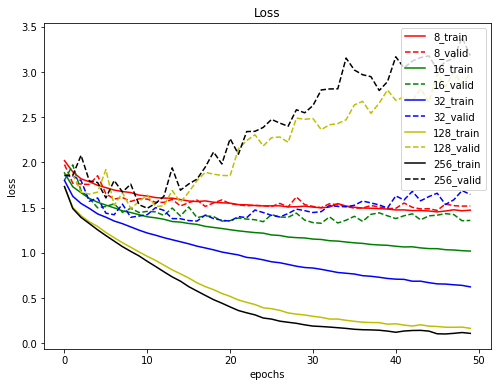

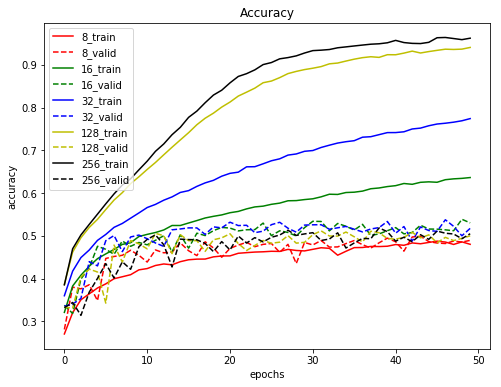

In [0]:
colors = ['r','g','b','y','k','m']
plt.figure(figsize = (8,6))

for i, cond in enumerate(results2.keys()):
    plt.plot(results2[cond]['train_loss'], '-', label = cond + "_train", color = colors[i])
    plt.plot(results2[cond]['valid_loss'], '--', label = cond + "_valid", color = colors[i])
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.figure(figsize = (8,6))
for i, cond in enumerate(results2.keys()):
    plt.plot(results2[cond]['train_acc'], '-', label = cond + '_train', color = colors[i])
    plt.plot(results2[cond]['valid_acc'], '--',label = cond + '_valid', color = colors[i])
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [0]:
def build_mlp3(input_shape, output_units = 10):
    
    input_layer = Input(input_shape, name = "main_input")
    x = keras.layers.Dense(units = 512)(input_layer)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dense(units = 512)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dense(units = 256)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dense(units = 256)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dense(units = 128)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    output_layer = Dense(units = output_units, activation = 'softmax', name = "main_output")(x)
    
    model = keras.models.Model(inputs = [input_layer], outputs = [output_layer])
    return model

In [0]:
model = build_mlp3(train_x.shape[1:])
optimizer = keras.optimizers.Adam(lr = lr)
  
model.compile(optimizer =optimizer, loss = "categorical_crossentropy", metrics = ['accuracy'])
history = model.fit(train_x, train_y, batch_size = 128, epochs =epochs, shuffle = True, validation_data = [test_x, test_y])

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 141us/step - loss: 1.6478 - acc: 0.4145 - val_loss: 1.6753 - val_acc: 0.3910
Epoch 2/50
50000/50000 [==============================] - 5s 109us/step - loss: 1.4055 - acc: 0.4985 - val_loss: 1.6651 - val_acc: 0.4203
Epoch 3/50
50000/50000 [==============================] - 5s 109us/step - loss: 1.2894 - acc: 0.5405 - val_loss: 1.6659 - val_acc: 0.4044
Epoch 4/50
50000/50000 [==============================] - 5s 109us/step - loss: 1.1997 - acc: 0.5734 - val_loss: 1.5071 - val_acc: 0.4713
Epoch 5/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.1205 - acc: 0.5999 - val_loss: 1.9385 - val_acc: 0.3724
Epoch 6/50
50000/50000 [==============================] - 5s 109us/step - loss: 1.0483 - acc: 0.6290 - val_loss: 1.6773 - val_acc: 0.4229
Epoch 7/50
50000/50000 [==============================] - 5s 109us/step - loss: 0.9713 - acc: 0.6548 - val_loss: 1.4975 - 

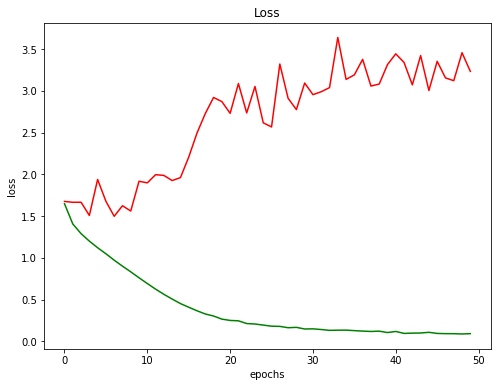

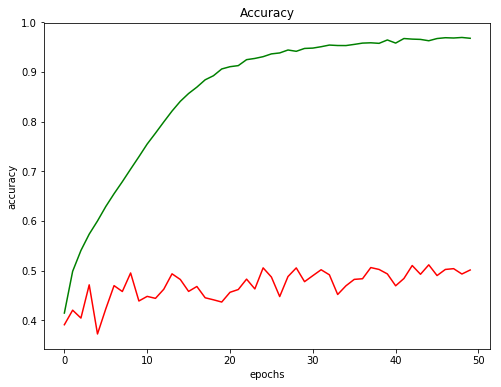

In [0]:

plt.figure(figsize = (8,6))
plt.plot(history.history['loss'], label = "train_loss", color = 'g')
plt.plot(history.history['val_loss'], label = "valid_loss", color = 'r')
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

plt.figure(figsize = (8,6))
plt.plot(history.history['acc'], label = "train_acc", color = 'g')
plt.plot(history.history['val_acc'], label = "valid_acc", color = 'r')
plt.title("Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.show()



In [0]:
def build_mlp4(input_shape, output_units = 10):
    
    input_layer = Input(input_shape, name = "main_input")
    x = keras.layers.BatchNormalization()(input_layer)
    x = keras.layers.Dense(units = 512)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dense(units = 512)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dense(units = 256)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dense(units = 256)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dense(units = 128)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    output_layer = Dense(units = output_units, activation = 'softmax', name = "main_output")(x)
    
    model = keras.models.Model(inputs = [input_layer], outputs = [output_layer])
    return model

In [0]:
model = build_mlp4(train_x.shape[1:])
optimizer = keras.optimizers.Adam(lr = lr)
  
model.compile(optimizer =optimizer, loss = "categorical_crossentropy", metrics = ['accuracy'])
history = model.fit(train_x, train_y, batch_size = 128, epochs =epochs, shuffle = True, validation_data = [test_x, test_y])

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.6451 - acc: 0.4130 - val_loss: 1.5099 - val_acc: 0.4667
Epoch 2/50
50000/50000 [==============================] - 6s 119us/step - loss: 1.4033 - acc: 0.5004 - val_loss: 1.4397 - val_acc: 0.4889
Epoch 3/50
50000/50000 [==============================] - 6s 118us/step - loss: 1.2823 - acc: 0.5447 - val_loss: 1.3550 - val_acc: 0.5150
Epoch 4/50
50000/50000 [==============================] - 6s 120us/step - loss: 1.1898 - acc: 0.5754 - val_loss: 1.3387 - val_acc: 0.5245
Epoch 5/50
50000/50000 [==============================] - 6s 120us/step - loss: 1.1097 - acc: 0.6020 - val_loss: 1.3144 - val_acc: 0.5378
Epoch 6/50
50000/50000 [==============================] - 6s 118us/step - loss: 1.0332 - acc: 0.6331 - val_loss: 1.3011 - val_acc: 0.5478
Epoch 7/50
50000/50000 [==============================] - 6s 119us/step - loss: 0.9542 - acc: 0.6593 - val_loss: 1.3189 - 

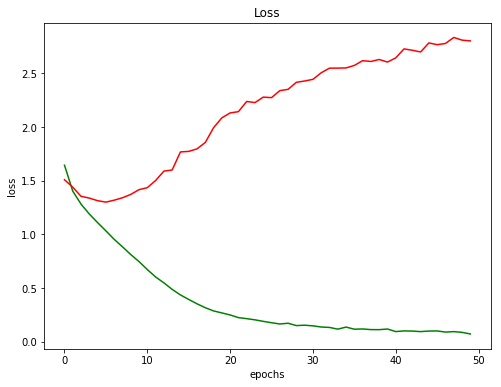

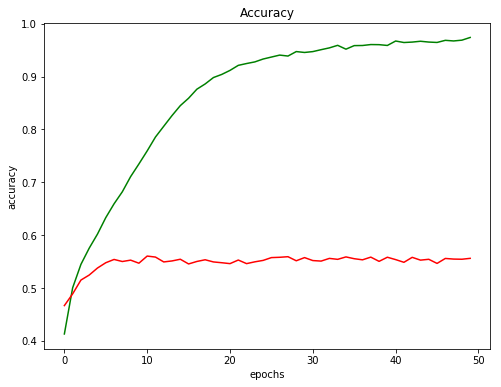

In [0]:

plt.figure(figsize = (8,6))
plt.plot(history.history['loss'], label = "train_loss", color = 'g')
plt.plot(history.history['val_loss'], label = "valid_loss", color = 'r')
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

plt.figure(figsize = (8,6))
plt.plot(history.history['acc'], label = "train_acc", color = 'g')
plt.plot(history.history['val_acc'], label = "valid_acc", color = 'r')
plt.title("Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.show()


